## Analyzing Europe's top forwards

#### This notebook analyzes which forwards outperformed their non-penalty expected goals (npxG) in 2024-25.


### Part I: Import Libraries
#### Load all necessary packages: pandas, numpy, matplotlib, adjustText, PIL, urllib, and os.

In [1]:
# Import the required libraries

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from adjustText import adjust_text
from PIL import Image
import urllib
import os
import numpy as np

### Part II: Access the Data
#### Create a custom function to scrape player stats from FBRef.com.

In [2]:
# Create a function to access data from FBRef
# For this analysis the data required is shooting data from Big 5 European Leagues

def access_player_shooting_data(url):
    try:
        # Read all tables from the webpage
        tables = pd.read_html(url, attrs={'id': 'stats_shooting'})
        
        # Check if the table exists
        if tables:
            return tables[0]  # Return the first table
        else:
            print("No table found with the specified ID.")
            return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

### Part III: Initial DataFrame
#### Parse the HTML and build the base DataFrame using the FBRef URL for the 2024/25 season.

In [3]:
# Provide the URL, save it into a variable called 'url'
url = 'https://fbref.com/en/comps/Big5/shooting/players/Big-5-European-Leagues-Stats'

# Call the function and save it to a variable called 'df'
df = access_player_shooting_data(url)

In [4]:
# Check the dataframe
df.head(10)

Unnamed: 0_level_0   Unnamed: 1_level_0 Unnamed: 2_level_0  \
                  Rk               Player             Nation   
0                  1           Max Aarons            eng ENG   
1                  2           Max Aarons            eng ENG   
2                  3       Rodrigo Abajas             es ESP   
3                  4       James Abankwah             ie IRL   
4                  5    Keyliane Abdallah             fr FRA   
5                  6     Yunis Abdelhamid             ma MAR   
6                  7        Himad Abdelli             dz ALG   
7                  8  Mohamed Abdelmoneim             eg EGY   
8                  9             Ali Abdi             tn TUN   
9                 10      Saud Abdulhamid             sa KSA   

  Unnamed: 3_level_0 Unnamed: 4_level_0  Unnamed: 5_level_0  \
                 Pos              Squad                Comp   
0                 DF        Bournemouth  eng Premier League   
1              DF,MF           Valencia          es La Liga   
2                 DF           Valencia          es La Liga   
3              DF,MF            Udinese          it Serie A   
4                 FW          Marseille          fr Ligue 1   
5                 DF      Saint-Étienne          fr Ligue 1   
6              MF,FW             Angers          fr Ligue 1   
7                 DF               Nice          fr Ligue 1   
8              DF,MF               Nice          fr Ligue 1   
9                 DF               Roma          it Serie A   

  Unnamed: 6_level_0 Unnamed: 7_level_0 Unnamed: 8_level_0 Standard  ...  \
                 Age               Born                90s      Gls  ...   
0                 24               2000                1.0        0  ...   
1                 24               2000                1.3        0  ...   
2                 21               2003                0.7        0  ...   
3                 20               2004                1.0        0  ...   
4                 18               2006                0.0        0  ...   
5                 36               1987               11.5        0  ...   
6                 24               1999               31.6        6  ...   
7                 25               1999                9.5        0  ...   
8                 30               1993               15.5        5  ...   
9                 25               1999                2.3        0  ...   

                    Expected                            Unnamed: 26_level_0  
   Dist FK PK PKatt       xG npxG npxG/Sh  G-xG np:G-xG             Matches  
0   NaN  0  0     0      0.0  0.0     NaN   0.0     0.0             Matches  
1   NaN  0  0     0      0.0  0.0     NaN   0.0     0.0             Matches  
2  24.5  0  0     0      0.1  0.1    0.07  -0.1    -0.1             Matches  
3  15.0  0  0     0      0.1  0.1    0.06  -0.1    -0.1             Matches  
4   NaN  0  0     0      0.0  0.0     NaN   0.0     0.0             Matches  
5  10.8  0  0     0      0.2  0.2    0.12  -0.2    -0.2             Matches  
6  22.6  0  3     4      6.4  3.2    0.09  -0.4    -0.2             Matches  
7   NaN  0  0     0      0.0  0.0     NaN   0.0     0.0             Matches  
8  16.9  1  0     0      4.3  4.3    0.17  +0.7    +0.7             Matches  
9  24.7  0  0     0      0.0  0.0    0.03   0.0     0.0             Matches  

[10 rows x 27 columns]

### Part IV: Data Cleaning & Filtering
#### Clean the data and filter for players with a primary position of forward (FW).

In [5]:
# Create a function to clean the dataframe

def clean_data(df):
    # Drop the top level columns (if multi-index)
    if df.columns.nlevels > 1:
        df = df.droplevel(0, axis=1)
    
    # Drop the 'Matches' column if it exists
    if 'Matches' in df.columns:
        df = df.drop('Matches', axis=1)
    
    # Convert the values in '90s' to numeric values, coercing errors
    df['90s'] = pd.to_numeric(df['90s'], errors='coerce')

    # Fill NaN values with 0.0
    df.fillna(0.0, inplace=True)

    # Convert '90s' into a float and create the 'minutes' column
    df['90s'] = df['90s'].astype(float)
    df['minutes'] = (df['90s'] * 90).round().astype(int)

    # Filter players based on position (e.g., only forwards 'FW')
    df = df[df['Pos'].str.contains('FW', na=False)]  # Added na=False to avoid issues with NaN values
    
    # Filter players based on minutes played (at least 1000 minutes)
    df = df[df['minutes'] >= 1000]

    # Clean up column names by stripping any leading/trailing spaces
    df.columns = df.columns.str.strip()

    # Convert specific columns to the appropriate data types
    if 'Gls' in df.columns:
        df['Gls'] = df['Gls'].astype(int)
    if 'PK' in df.columns:
        df['PK'] = df['PK'].astype(int)
    if 'npxG' in df.columns:
        df['npxG'] = df['npxG'].astype(float)

    # Create a column for non-penalty goals (npG)
    df['npG'] = (df['Gls']-df['PK']).round().astype(int)
    
    # Optional: Pivot the DataFrame if necessary (e.g., based on 'Statistic' and 'Percentile')
    #if 'Statistic' in df.columns and 'Percentile' in df.columns:
        #df = df.pivot_table(columns='Statistic', values='Percentile', aggfunc='mean')

    return df

In [6]:
# Call the function and save it to 'df' (alternatively safe it to 'clean_df')
df = clean_data(df)

In [7]:
# Check the dataframe again
df

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Gls,...,FK,PK,PKatt,xG,npxG,npxG/Sh,G-xG,np:G-xG,minutes,npG
6,7,Himad Abdelli,dz ALG,"MF,FW",Angers,fr Ligue 1,24,1999,31.6,6,...,0,3,4,6.4,3.2,0.09,-0.4,-0.2,2844,3
13,14,Matthis Abline,fr FRA,FW,Nantes,fr Ligue 1,21,2003,30.8,9,...,0,1,1,8.5,7.7,0.11,+0.5,+0.3,2772,8
15,16,Zakaria Aboukhlal,ma MAR,"MF,FW",Toulouse,fr Ligue 1,24,2000,21.1,7,...,0,1,2,10.2,8.6,0.14,-3.2,-2.6,1899,6
18,19,Tammy Abraham,eng ENG,FW,Milan,it Serie A,26,1997,13.1,3,...,0,1,2,7.1,5.4,0.21,-4.1,-3.4,1179,2
23,24,Akor Adams,ng NGA,FW,Montpellier,fr Ligue 1,24,2000,11.9,3,...,0,0,0,4.3,4.3,0.16,-1.3,-1.3,1071,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2931,2820,Alessandro Zanoli,it ITA,"FW,DF",Genoa,it Serie A,23,2000,19.0,1,...,0,0,0,0.4,0.4,0.04,+0.6,+0.6,1710,1
2935,2824,Bryan Zaragoza,es ESP,"FW,MF",Osasuna,es La Liga,23,2001,20.4,1,...,0,0,0,2.7,2.7,0.06,-1.7,-1.7,1836,1
2936,2825,Anass Zaroury,ma MAR,"FW,MF",Lens,fr Ligue 1,23,2000,15.6,2,...,0,0,0,1.7,1.7,0.05,+0.3,+0.3,1404,2
2954,2842,Joshua Zirkzee,nl NED,"FW,MF",Manchester Utd,eng Premier League,23,2001,15.6,3,...,0,0,0,4.8,4.8,0.17,-1.8,-1.8,1404,3


### Part V: Performance Labeling
#### Add a flag column to label each player as overperforming or underperforming based on the difference between npG and npxG.

In [8]:
def calculate_performance_flags(df):
    """
    Calculate overperformance using the raw difference (npG - npxG)
    and flag players as overperforming or underperforming.

    Parameters:
        df (pd.DataFrame): The cleaned DataFrame with 'npG' and 'npxG' columns.

    Returns:
        pd.DataFrame: Modified DataFrame with overperformance values and flags.
    """
    # Step 1: Calculate overperformance
    df['overperformance'] = df['npG'] - df['npxG']

    # Step 2: Add flags
    df['overperforming'] = df['overperformance'] > 0
    df['underperforming'] = df['overperformance'] < 0

    # Optional: Filter subsets
    overperforming_players = df[df['overperforming']]
    underperforming_players = df[df['underperforming']]

    return df, overperforming_players, underperforming_players

In [9]:
# Call the function
calculate_performance_flags(df)

(        Rk             Player   Nation    Pos           Squad  \
 6        7      Himad Abdelli   dz ALG  MF,FW          Angers   
 13      14     Matthis Abline   fr FRA     FW          Nantes   
 15      16  Zakaria Aboukhlal   ma MAR  MF,FW        Toulouse   
 18      19      Tammy Abraham  eng ENG     FW           Milan   
 23      24         Akor Adams   ng NGA     FW     Montpellier   
 ...    ...                ...      ...    ...             ...   
 2931  2820  Alessandro Zanoli   it ITA  FW,DF           Genoa   
 2935  2824     Bryan Zaragoza   es ESP  FW,MF         Osasuna   
 2936  2825      Anass Zaroury   ma MAR  FW,MF            Lens   
 2954  2842     Joshua Zirkzee   nl NED  FW,MF  Manchester Utd   
 2966  2853        Milan Đurić   ba BIH     FW           Monza   
 
                     Comp Age  Born   90s  Gls  ...    xG npxG npxG/Sh  G-xG  \
 6             fr Ligue 1  24  1999  31.6    6  ...   6.4  3.2    0.09  -0.4   
 13            fr Ligue 1  21  2003  30.8    9

In [10]:
df.head(10)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Gls,...,xG,npxG,npxG/Sh,G-xG,np:G-xG,minutes,npG,overperformance,overperforming,underperforming
6,7,Himad Abdelli,dz ALG,"MF,FW",Angers,fr Ligue 1,24,1999,31.6,6,...,6.4,3.2,0.09,-0.4,-0.2,2844,3,-0.2,False,True
13,14,Matthis Abline,fr FRA,FW,Nantes,fr Ligue 1,21,2003,30.8,9,...,8.5,7.7,0.11,+0.5,+0.3,2772,8,0.3,True,False
15,16,Zakaria Aboukhlal,ma MAR,"MF,FW",Toulouse,fr Ligue 1,24,2000,21.1,7,...,10.2,8.6,0.14,-3.2,-2.6,1899,6,-2.6,False,True
18,19,Tammy Abraham,eng ENG,FW,Milan,it Serie A,26,1997,13.1,3,...,7.1,5.4,0.21,-4.1,-3.4,1179,2,-3.4,False,True
23,24,Akor Adams,ng NGA,FW,Montpellier,fr Ligue 1,24,2000,11.9,3,...,4.3,4.3,0.16,-1.3,-1.3,1071,3,-1.3,False,True
24,25,Che Adams,sct SCO,FW,Torino,it Serie A,28,1996,29.5,9,...,9.0,8.2,0.13,0.0,+0.8,2655,9,0.8,True,False
27,27,Junior Adamu,at AUT,FW,Freiburg,de Bundesliga,23,2001,17.2,2,...,5.5,5.5,0.16,-3.5,-3.5,1548,2,-3.5,False,True
30,30,Karim Adeyemi,de GER,"FW,MF",Dortmund,de Bundesliga,22,2002,15.9,7,...,5.5,5.5,0.12,+1.5,+1.5,1431,7,1.5,True,False
31,31,Simon Adingra,ci CIV,"FW,MF",Brighton,eng Premier League,22,2002,12.2,2,...,2.5,2.5,0.07,-0.5,-0.5,1098,2,-0.5,False,True
38,38,Oladapo Afolayan,eng ENG,"FW,MF",St. Pauli,de Bundesliga,26,1998,18.2,3,...,3.1,3.1,0.08,-0.1,-0.1,1638,3,-0.1,False,True


### Part VI: Top 10 Overperformers
#### Filter the dataset to highlight the top 10 forwards with the highest overperformance.

In [11]:
# Step 1: Compute median minutes played
median_minutes = df['minutes'].median()

# Step 2: Filter players with minutes above median
eligible_players = df[df['minutes'] > median_minutes]

# Step 3: Sort by overperformance (or z-score)
top_overperformers = eligible_players.sort_values(by='overperformance', ascending=False).head(10)

# Step 4: Select only relevant columns
top_overperformers = top_overperformers[['Player', 'Squad', 'minutes', 
                                         'Sh/90', 'SoT/90', 'npG', 'npxG', 'Gls',
                                         'overperformance']]

In [12]:
top_overperformers

,Player,Squad,minutes,Sh/90,SoT/90,npG,npxG,Gls,overperformance
1760,Bryan Mbeumo,Brentford,3411,2.08,0.90,15,7.5,20,7.5
662,Matheus Cunha,Wolves,2601,3.81,1.52,15,8.6,15,6.4
2171,Ayoze Pérez,Villarreal,1971,3.43,1.42,19,12.7,19,6.3
2289,Mateo Retegui,Atalanta,2385,3.74,1.21,21,14.9,25,6.1
2898,Chris Wood,Nott'ham Forest,2961,1.98,0.97,17,11.0,20,6.0
1758,Kylian Mbappé,Real Madrid,2907,4.71,2.32,24,18.6,31,5.4
2595,Lucas Stassin,Saint-Étienne,1890,2.10,1.10,12,7.0,12,5.0
1102,Mason Greenwood,Marseille,2808,3.56,1.44,14,9.1,21,4.9
2255,Sandro Ramírez,Las Palmas,2034,2.26,0.88,8,3.3,9,4.7
1573,Ademola Lookman,Atalanta,2250,3.24,1.28,14,9.5,15,4.5


In [13]:
# Create a function that takes only certain columns from the 'top_overperformers' dataframe
def create_dataframe_for_table(df):
    """
    Selects specific columns from the input DataFrame and returns a new DataFrame.

    Parameters:
    - df: The input DataFrame.

    Returns:
    - A DataFrame with only the selected columns: Player, Squad, minutes, Gls, 
    Sh/90, SoT/90, npxG, np:G-xG, PK.
    """
    table_df = df[['Player', 'Squad', 'minutes', 'Sh/90', 'SoT/90',
                   'Gls', 'npG', 'npxG', 'overperformance', ]]
    table_df['overperformance'] = table_df['overperformance'].round(2).astype(float)

    return table_df

In [14]:
table_df = create_dataframe_for_table(top_overperformers)

In [15]:
table_df

,Player,Squad,minutes,Sh/90,SoT/90,Gls,npG,npxG,overperformance
1760,Bryan Mbeumo,Brentford,3411,2.08,0.90,20,15,7.5,7.5
662,Matheus Cunha,Wolves,2601,3.81,1.52,15,15,8.6,6.4
2171,Ayoze Pérez,Villarreal,1971,3.43,1.42,19,19,12.7,6.3
2289,Mateo Retegui,Atalanta,2385,3.74,1.21,25,21,14.9,6.1
2898,Chris Wood,Nott'ham Forest,2961,1.98,0.97,20,17,11.0,6.0
1758,Kylian Mbappé,Real Madrid,2907,4.71,2.32,31,24,18.6,5.4
2595,Lucas Stassin,Saint-Étienne,1890,2.10,1.10,12,12,7.0,5.0
1102,Mason Greenwood,Marseille,2808,3.56,1.44,21,14,9.1,4.9
2255,Sandro Ramírez,Las Palmas,2034,2.26,0.88,9,8,3.3,4.7
1573,Ademola Lookman,Atalanta,2250,3.24,1.28,15,14,9.5,4.5


### Part VII: Team Badge Integration
#### Dynamically fetch and embed team logos next to each player's name using PIL and urllib.

In [16]:
# Create a function to get each players's club's logo
def ax_logo(team_id, ax, team_id_dict):
    '''
    Plots the logo of the team at a specific axes.
    Args:
        team_id (int): the id of the team according to Fotmob. You can find it in the url of the team page.
        ax (object): the matplotlib axes where we'll draw the image.
    '''
    team_id = team_id_dict.get(team_id)
    if team_id is None:
        raise ValueError(f"Team ID for '{team_name}' not found in the dictionary.")
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_id}.png'))
    ax.imshow(club_icon)
    ax.axis('off')
    return ax

In [17]:
team_id_dict = {
    'Atalanta': 8524,
    'Brentford': 9937 ,
    'Las Palmas': 8306 ,
    'Marseille': 8592,
    "Nott'ham Forest": 10203,
    'Real Madrid': 8633,
    'Saint-Étienne': 9853,
    'Villarreal': 10205,
    'Wolves': 8602,
}

### Part VIII: Create Ranked Table
#### Generate a clean, stylized summary table of the top performers using matplotlib.

In [18]:
def create_table(df):
    df = table_df.sort_values(by='overperformance', ascending=True).reset_index(drop=True)
    df = df.rename(columns={'minutes': 'Mins', 'overperformance': 'Overperformance'})
    df['Overperformance'] = df['Overperformance'].apply(lambda x: f'+{x:.1f}' if x > 0 else f'{x:.1f}')

    fig = plt.figure(figsize=(14,6), dpi=300, facecolor='#F1E5E1')
    ax = plt.subplot()
    
    ncols = len(df.columns) + 1  # Dynamically calculate number of columns
    nrows = df.shape[0]
    
    ax.set_xlim(0.4, ncols + 1)
    ax.set_ylim(0, nrows + 1)
    
    # Dynamically generate column positions based on the number of columns
    step_sizes = [0.7, 3, 1, 0.85, 0.85, 0.85, 0.85, 0.85, 1.1]
    positions = [sum(step_sizes[:i+1]) for i in range(ncols)]
    columns = df.columns.tolist()  # Use the dataframe columns directly
    
    # Add table's main text
    for i in range(nrows):
        for j, column in enumerate(columns):
            if j == 0:
                ha = 'left'
            else:
                ha = 'center'
            text_label = f'{df[column].iloc[i]}'
            weight = 'normal'
            if column == 'Overperformance':
                weight = 'bold'
            ax.annotate(
                xy=(positions[j], i + .5),
                text=text_label,
                ha=ha,
                va='center',
                weight=weight
            )
    
    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    
    ax_point_1 = DC_to_NFC([0.95, 0.95])
    ax_point_2 = DC_to_NFC([0.25, 0.25])
    ax_width = abs(ax_point_1[0] - ax_point_2[0])
    ax_height = abs(ax_point_1[0] - ax_point_2[0])
    
    # Add logos for each team
    for x in range(0, nrows):
        ax_coords = DC_to_NFC([2.25, x + 0.15])
        badge_ax = fig.add_axes(
            [ax_coords[0], ax_coords[1], ax_width, ax_height]
        )
        team_name = df['Squad'].iloc[x]
        team_id = team_id_dict.get(team_name)  # Fetch team_id from the dictionary
        ax_logo(team_name, badge_ax, team_id_dict)
    
    # Add column names at the top
    for index, c in enumerate(columns):
            ha = 'left' if index == 0 else 'center'
            ax.annotate(
                xy=(positions[index], nrows + .25),
                text=c,
                ha=ha,
                va='bottom',
                weight='bold'
            )
    
    # Add dividing lines
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
    for x in range(1, nrows):
        ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')
    
    # Add title to the table
    fig.text(0.5, 0.95, "Top 10 forwards in Europe's Big 5 Leagues", ha='center', va='bottom', fontsize=14, weight='bold', color='#5A5A5A')
    # Add subtitle to the table
    fig.text(0.5, 0.9, "Based on non-penalty goals (npG) and non-penalty expected Goals (npxG), sorted by overperformance | Season 2024-25", ha='center', va='bottom', fontsize=12, color='#5A5A5A')
    # Add annotation at the bottom-left corner
    fig.text(0.1, 0.05, "Viz by jsonrbrt.bsky.social | data from FBRef.com", ha='left', va='bottom', fontsize=8, color='#5A5A5A')

    ax.set_axis_off()
    plt.savefig('top_overperformers.png', dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())

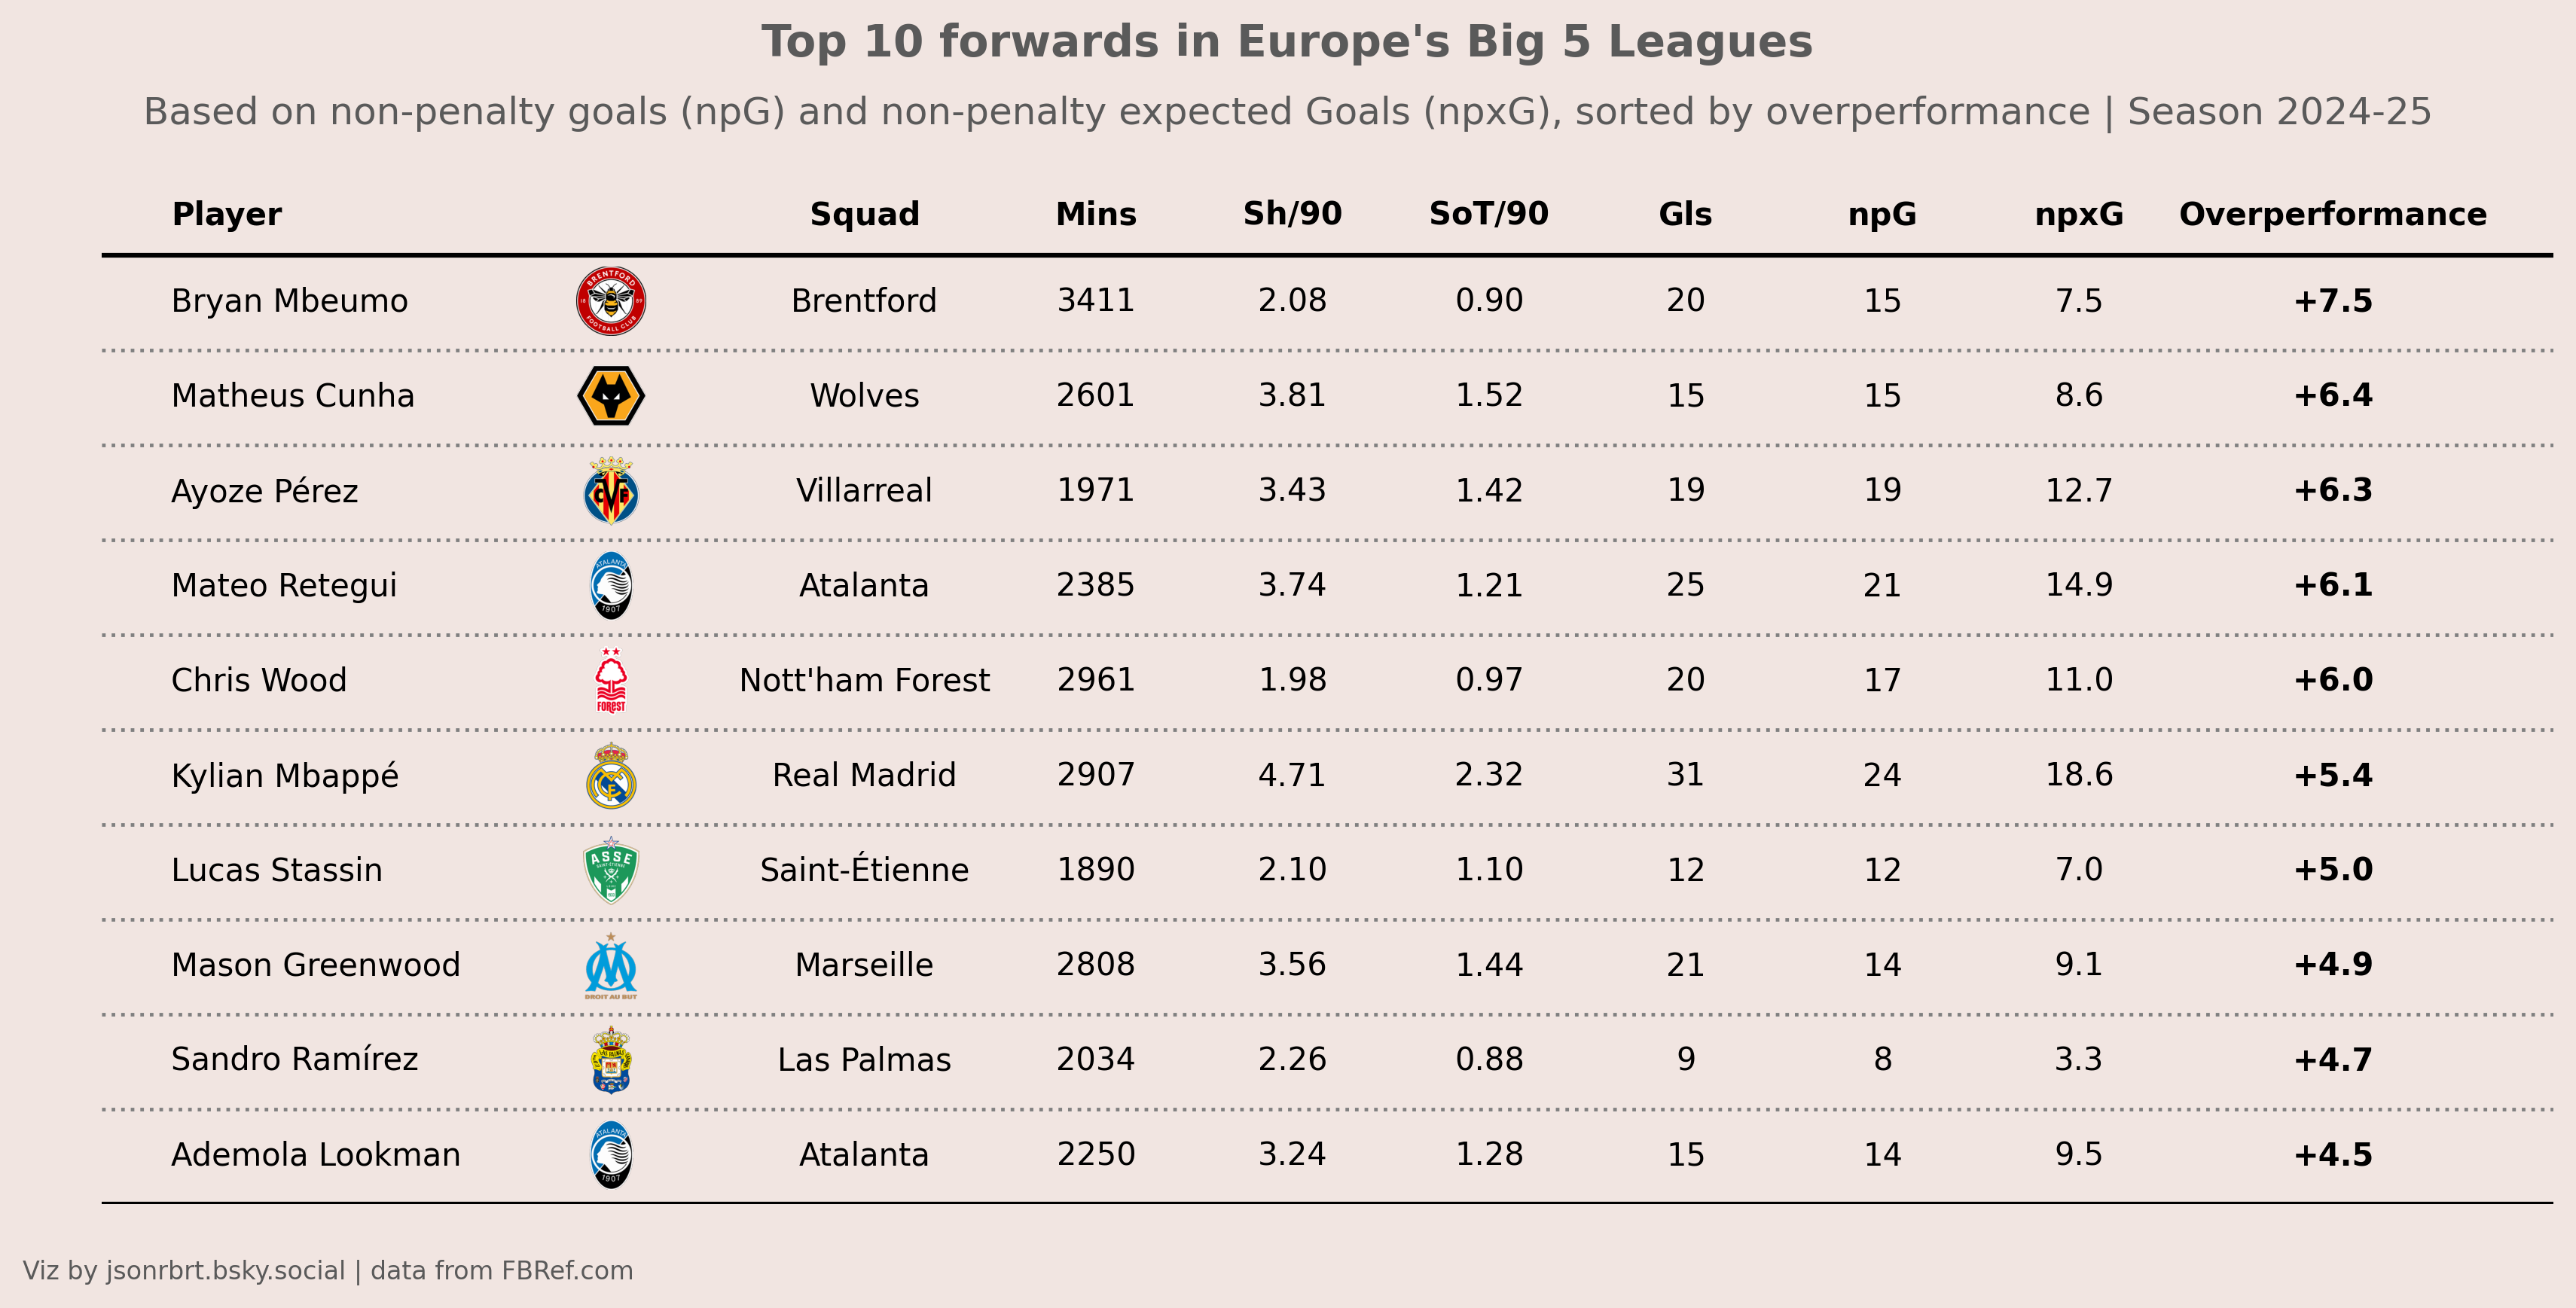

In [19]:
create_table(table_df)

### Takeaways

#### Leading all attackers across Europe are Bryan Mbeumo and Matheus Cunha, they combined for 30 non-penalty goals, outperforming their npxG by nearly 14 goals. Wolves is banking a cool £62.5m after Manchester United signed Cunha. United is also pursuing Mbeumo, potentially putting together the league's top over-performers for npxG from last season, take that for data!

#### Other interesting tidbit:
#### 📉 Premier League anomaly: The top three overperformers—Mbeumo (Brentford), Cunha (Wolves), and Wood (Forest)—all come from clubs that finished outside the top six (10th, 16th, 7th respectively). Finishing isn’t always a function of elite team performance.
#### 🇮🇹 Atalanta’s forward firepower: With both Mateo Retegui and Ademola Lookman in the top 10, Ivan Jurić inherits an attacking legacy from Gasperini. Few Serie A clubs are as efficient in converting chances.
#### 🔁 Premier League exports are thriving: A surprising number of top overperformers are ex-PL players: Ayoze Pérez, Greenwood, Sandro Ramírez, and Lookman. For clubs seeking value, the Premier League’s fringe players might be an underrated market.

### Part IX: Scatter Plot Visualization
#### Plot npxG vs. npG for all qualifying forwards, highlighting top overperformers by color and size (based on minutes played).

In [20]:
def improved_plot_overperformers_scatter(df, top_n=10, theme='light', save_path=None):
    """
    Enhanced scatter plot for npxG vs npG, highlighting top overperformers.

    Parameters:
        df (pd.DataFrame): Must contain 'npxG', 'npG', 'overperformance', 'minutes', 'Player', 'overperforming'
        top_n (int): Number of top players to highlight
        theme (str): 'light' or 'dark' background theme
        save_path (str): Optional path to save the figure as PNG
    """

    # Theme settings
    if theme == 'dark':
        bg_color = '#1e1e1e'
        text_color = '#F0F0F0'
        grid_color = '#444'
        scatter_grey = '#888'
        edge_color = 'white'
    else:  # light
        bg_color = '#FFFFFF'
        text_color = '#404040'
        grid_color = 'lightgrey'
        scatter_grey = '#A9A9A9'
        edge_color = 'black'

    median_minutes = df['minutes'].median()
    eligible_players = df[df['minutes'] > median_minutes]

    top_overperformers = eligible_players[eligible_players['overperforming']] \
        .sort_values(by='overperformance', ascending=False).head(top_n).reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(18, 12), dpi=100, facecolor=bg_color)
    ax.set_facecolor(bg_color)
    ax.grid(visible=True, ls='--', color=grid_color, alpha=0.6)

    ax.scatter(
        eligible_players['npxG'], eligible_players['npG'],
        color=scatter_grey, alpha=0.3, s=60, label='All Forwards', zorder=1
    )

    sizes = top_overperformers['minutes'] / 10
    cmap = cm.get_cmap('viridis_r')

    scatter = ax.scatter(
        top_overperformers['npxG'], top_overperformers['npG'],
        c=top_overperformers['overperformance'], cmap=cmap,
        edgecolor=edge_color, s=sizes * 1.2, zorder=2, label='Top Overperformers',
        vmin=0  # Normalize color scale from 0
    )

    top1 = top_overperformers.iloc[0]
    ax.scatter(top1['npxG'], top1['npG'], s=200, facecolors='none',
               edgecolors='pink', linewidths=1.5, zorder=4, label='Top Performer')

    max_val = max(eligible_players['npxG'].max(), eligible_players['npG'].max()) + 1
    ax.plot([0, max_val], [0, max_val], '--', color='black', lw=1.5, zorder=0)

    texts = []
    for _, row in top_overperformers.iterrows():
        text = ax.text(
            row['npxG'], row['npG'], row['Player'],
            fontsize=10, ha='center', va='center', weight='bold',
            color=text_color,
            path_effects=[
                patheffects.Stroke(linewidth=3, foreground=bg_color),
                patheffects.Normal()
            ],
            zorder=3
        )
        texts.append(text)

    adjust_text(texts, only_move={'points': 'y', 'text': 'xy', 'objects': 'xy'})

    ax.set_xlabel('Non-penalty Expected Goals (npxG)', fontsize=13, weight='bold', color=text_color)
    ax.set_ylabel('Non-penalty Goals Scored (npG)', fontsize=13, weight='bold', color=text_color)
    ax.set_title("Europe's Most Lethal Attackers", fontsize=18, weight='bold', pad=20, loc='left', color=text_color)

    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.03, aspect=20)
    cbar.set_label('Non-penalty Expected Goals Overperformance', fontsize=11, weight='bold', color=text_color)
    cbar.ax.yaxis.set_tick_params(color=text_color)
    plt.setp(cbar.ax.get_yticklabels(), color=text_color)
    cbar.outline.set_visible(False)

    # Description text
    plt.figtext(
        x=0.035, y=0.94,
        s="Non-penalty expected goals and non-penalty goals scored across Europe's Big 5 leagues",
        va="bottom", ha="left", fontsize=10, color=text_color
    )
    plt.figtext(
        x=0.035, y=0.91,
        s="Only forwards with above median minutes are shown \nViz by @jsonrbrt.bsky.social | Season 2024/2025",
        va="bottom", ha="left", fontsize=10, color=text_color
    )
    plt.figtext(
        x=0.77, y=0.91,
        s="• Circle size ∝ minutes played", fontsize=10, color=text_color
    )

    ax.legend(frameon=False, loc='upper left', fontsize=11, labelspacing=1.2)

    plt.tight_layout(rect=[0, 0, 1, 0.9])

    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight", transparent=False)

    plt.show()
    return fig, ax


/var/folders/vw/4r9rm0553n95pm4ckhlrdctr0000gn/T/ipykernel_19315/2077800619.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis_r')


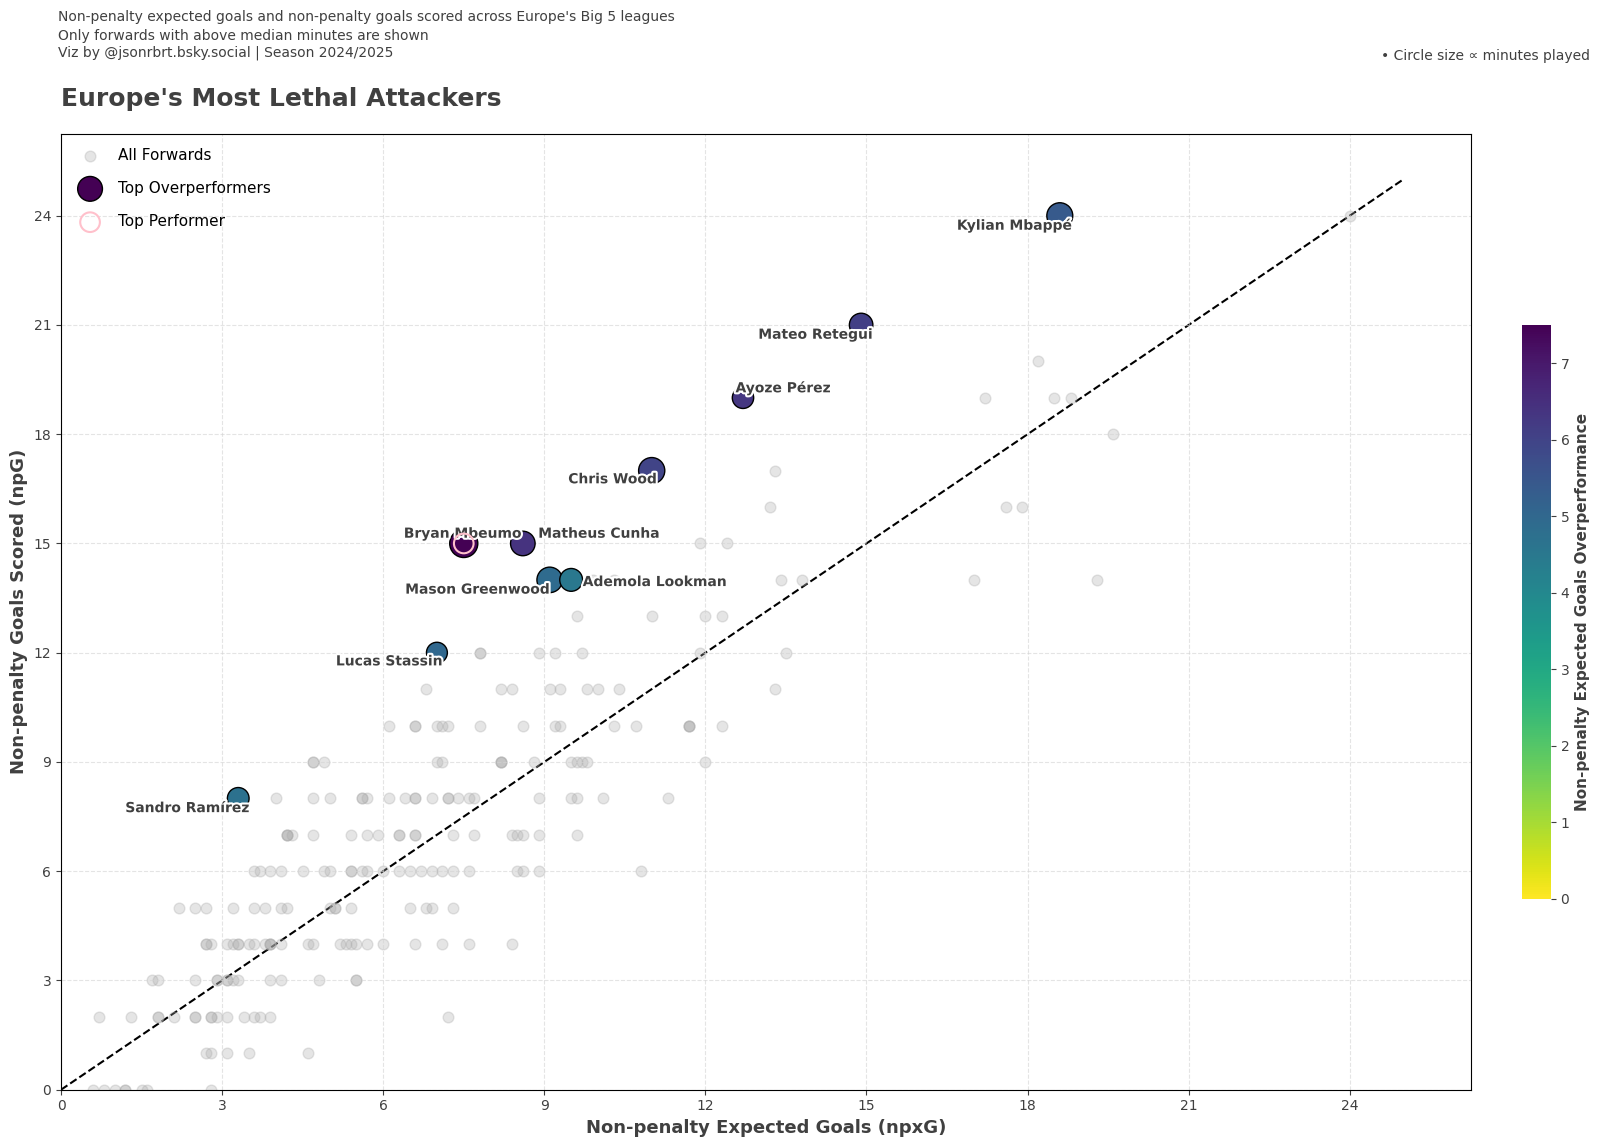

(<Figure size 1800x1200 with 2 Axes>,
 <Axes: title={'left': "Europe's Most Lethal Attackers"}, xlabel='Non-penalty Expected Goals (npxG)', ylabel='Non-penalty Goals Scored (npG)'>)

In [21]:
improved_plot_overperformers_scatter(df, 10, 'light', '/Users/jasonrobert/Desktop/npxg_scatter_light.png')